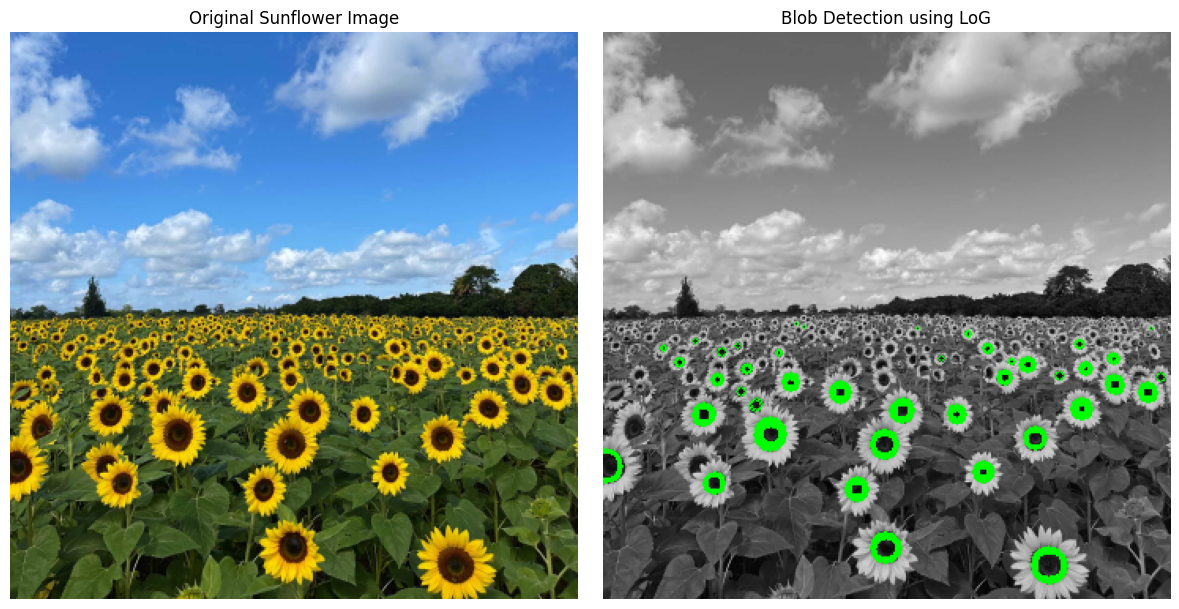

Sigma values used: [np.float64(0.71), np.float64(1.41), np.float64(2.12), np.float64(2.83), np.float64(3.54), np.float64(4.24), np.float64(4.95), np.float64(5.66), np.float64(6.36), np.float64(7.07)]
Largest detected blob radius: r = 10 pixels


In [ ]:
# --- EN3160 Assignment 2: Blob Detection using Laplacian of Gaussian (LoG) ---
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# --- Step 1: Load and convert image to grayscale ---
# (upload the image first or mount Drive; adjust path accordingly)
img_path = '/content/the_berry_farms_sunflower_field.jpeg'

im = cv.imread(img_path, cv.IMREAD_REDUCED_COLOR_4)
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
gray = gray.astype(np.float64) / 255.0

# --- Step 2: Initialize parameters ---
coordinates = []        # store blob centers
threshold = 0.1          # response threshold
radius_range = range(1, 11)  # r = 1 to 10

# --- Step 3: Loop over radius values (convert to sigma) ---
for r in radius_range:
    sigma = r / np.sqrt(2)   # relation: r = √2 * σ
    hw = round(3 * sigma)    # kernel half-width

    # Create coordinate grid
    X, Y = np.meshgrid(np.arange(-hw, hw + 1),
                       np.arange(-hw, hw + 1))

    # Laplacian of Gaussian kernel
    LOG = ((X**2 + Y**2) / (2 * sigma**2) - 1) \
          * np.exp(-(X**2 + Y**2) / (2 * sigma**2)) \
          / (np.pi * sigma**4)

    LOG = sigma**2 * LOG   # scale-normalized LoG kernel

    # --- Step 4: Filter image and square the response ---
    img_log = np.square(cv.filter2D(gray, -1, LOG))
    H, W = img_log.shape
    k = 1  # neighborhood radius for local maxima search

    # --- Step 5: Detect local maxima ---
    for i in range(k, H - k):
        for j in range(k, W - k):
            patch = img_log[i - k:i + k + 1, j - k:j + k + 1]
            if np.max(patch) >= threshold:
                x, y = np.unravel_index(patch.argmax(), patch.shape)
                coordinates.append((i + x - k, j + y - k, r))

# Remove duplicates
coordinates = list(set(coordinates))

# --- Step 6: Draw blobs on a copy of the grayscale image ---
output = cv.cvtColor((gray * 255).astype(np.uint8), cv.COLOR_GRAY2BGR)
for (y, x, r) in coordinates:
    cv.circle(output, (x, y), r, (0, 255, 0), 1)

# --- Step 7: Display results side by side ---
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB))
axes[0].set_title("Original Sunflower Image")
axes[0].axis('off')

axes[1].imshow(cv.cvtColor(output, cv.COLOR_BGR2RGB))
axes[1].set_title("Blob Detection using LoG")
axes[1].axis('off')

plt.tight_layout()
plt.show()

# --- Step 8: Print Sigma values used ---
sigmas = [r / np.sqrt(2) for r in radius_range]
print("Sigma values used:", [round(s, 2) for s in sigmas])
print("Largest detected blob radius: r = 10 pixels")


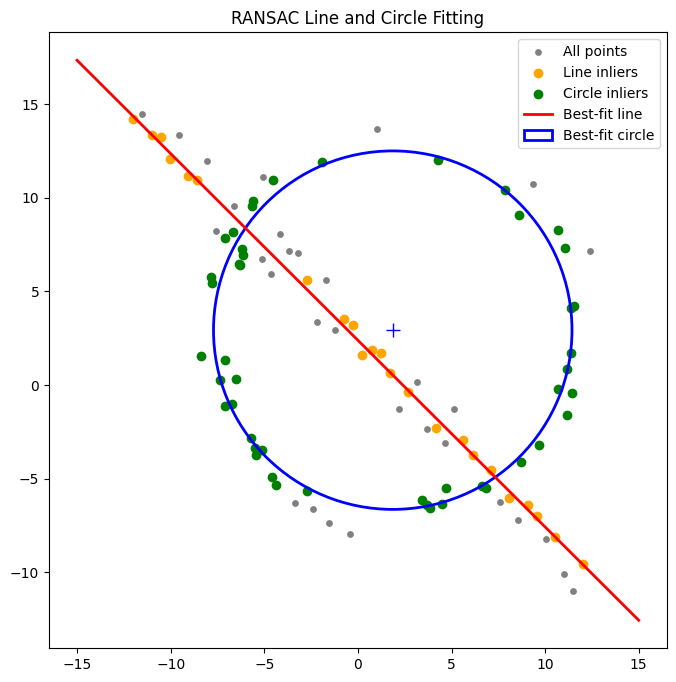

Estimated line parameters: a=0.706, b=0.708, d=-1.692
Estimated circle center: (1.86, 2.93), radius=9.57


In [ ]:
# --- EN3160 Assignment 2 – RANSAC Line and Circle Fitting ---
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

np.random.seed(0)

# --- Step 1: Generate noisy data ---
N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3   # Ground-truth circle center
s = r / 16

# Circle points (half of data)
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x = x0_gt + (r + n) * np.cos(t)
y = y0_gt + (r + n) * np.sin(t)
X_circ = np.vstack((x, y)).T

# Line points (remaining half)
s = 1.0
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.vstack((x, y)).T

# Combine both
X = np.vstack((X_circ, X_line))

# --- Step 2: Define helper functions ---
def line_from_points(p1, p2):
    # ax + by + d = 0, normalize so sqrt(a^2+b^2)=1
    x1, y1 = p1; x2, y2 = p2
    a = y1 - y2
    b = x2 - x1
    d = -(a * x1 + b * y1)
    norm = np.sqrt(a**2 + b**2)
    return a / norm, b / norm, d / norm

def dist_line(a, b, d, pts):
    return np.abs(a * pts[:,0] + b * pts[:,1] + d)

def circle_from_points(p1, p2, p3):
    # Compute circle (x0,y0,r) from 3 non-collinear points
    A = np.array([
        [p1[0], p1[1], 1],
        [p2[0], p2[1], 1],
        [p3[0], p3[1], 1]
    ])
    B = -np.array([
        [p1[0]**2 + p1[1]**2],
        [p2[0]**2 + p2[1]**2],
        [p3[0]**2 + p3[1]**2]
    ])
    sol = np.linalg.lstsq(A, B, rcond=None)[0].flatten()
    x0 = -sol[0]/2; y0 = -sol[1]/2
    r = np.sqrt((sol[0]**2 + sol[1]**2)/4 - sol[2])
    return x0, y0, r

def dist_circle(x0, y0, r, pts):
    return np.abs(np.sqrt((pts[:,0]-x0)**2 + (pts[:,1]-y0)**2) - r)

# --- Step 3: RANSAC for line fitting ---
def ransac_line(pts, thresh=0.5, iters=500):
    best_inliers = []
    best_model = None
    for _ in range(iters):
        p1, p2 = pts[np.random.choice(len(pts), 2, replace=False)]
        a,b,d = line_from_points(p1,p2)
        errs = dist_line(a,b,d,pts)
        inliers = np.where(errs < thresh)[0]
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_model = (a,b,d)
    return best_model, best_inliers

line_model, line_inliers = ransac_line(X, thresh=0.4)
a,b,d = line_model

# --- Step 4: Fit circle on remaining points ---
remnant = np.delete(X, line_inliers, axis=0)

def ransac_circle(pts, thresh=0.6, iters=500):
    best_inliers = []
    best_model = None
    for _ in range(iters):
        p1,p2,p3 = pts[np.random.choice(len(pts),3,replace=False)]
        try:
            x0,y0,r = circle_from_points(p1,p2,p3)
        except np.linalg.LinAlgError:
            continue
        errs = dist_circle(x0,y0,r,pts)
        inliers = np.where(errs < thresh)[0]
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_model = (x0,y0,r)
    return best_model, best_inliers

circle_model, circle_inliers = ransac_circle(remnant, thresh=0.8)
x0,y0,r = circle_model

# --- Step 5: Visualization ---
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(X[:,0], X[:,1], color='gray', s=15, label='All points')
ax.scatter(X[line_inliers,0], X[line_inliers,1], color='orange', label='Line inliers')
ax.scatter(remnant[circle_inliers,0], remnant[circle_inliers,1], color='green', label='Circle inliers')

# Best-fit line
x_line = np.linspace(-15,15,100)
y_line = -(a*x_line + d)/b
ax.plot(x_line, y_line, 'r-', linewidth=2, label='Best-fit line')

# Best-fit circle
circle_plot = plt.Circle((x0,y0), r, color='b', fill=False, linewidth=2, label='Best-fit circle')
ax.add_patch(circle_plot)
ax.plot(x0, y0, '+b', markersize=10)

ax.set_aspect('equal')
ax.legend()
plt.title('RANSAC Line and Circle Fitting')
plt.show()

print(f"Estimated line parameters: a={a:.3f}, b={b:.3f}, d={d:.3f}")
print(f"Estimated circle center: ({x0:.2f}, {y0:.2f}), radius={r:.2f}")


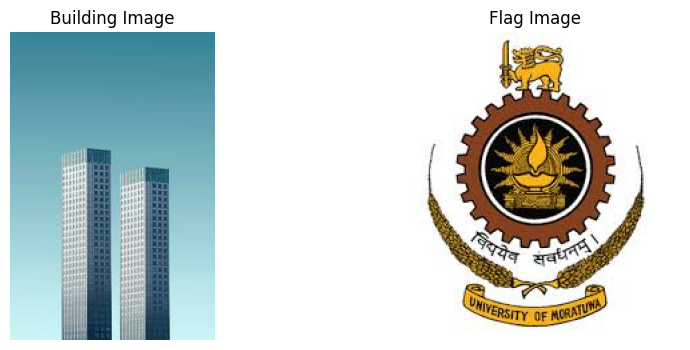

In [ ]:
# --- EN3160 Assignment 2 - Question 3: Homography Transformation ---
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Step 1: Load your two images ---
# Upload or mount them in /content/
building_img = cv2.imread('/content/img2.jpeg')
flag_img = cv2.imread('/content/img3.jpeg')

# Convert to RGB for matplotlib display
building_rgb = cv2.cvtColor(building_img, cv2.COLOR_BGR2RGB)
flag_rgb = cv2.cvtColor(flag_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(building_rgb)
plt.title("Building Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(flag_rgb)
plt.title("Flag Image")
plt.axis('off')
plt.show()


In [ ]:
points_building = np.array([
    [47,110],
    [69,105],
    [70,273],
    [47,273]
], dtype=np.float32)

# Points in flag image corners
pts_flag = np.array([
    [0, 0],
    [flag_img.shape[1], 0],
    [flag_img.shape[1], flag_img.shape[0]],
    [0, flag_img.shape[0]]
], dtype=np.float32)

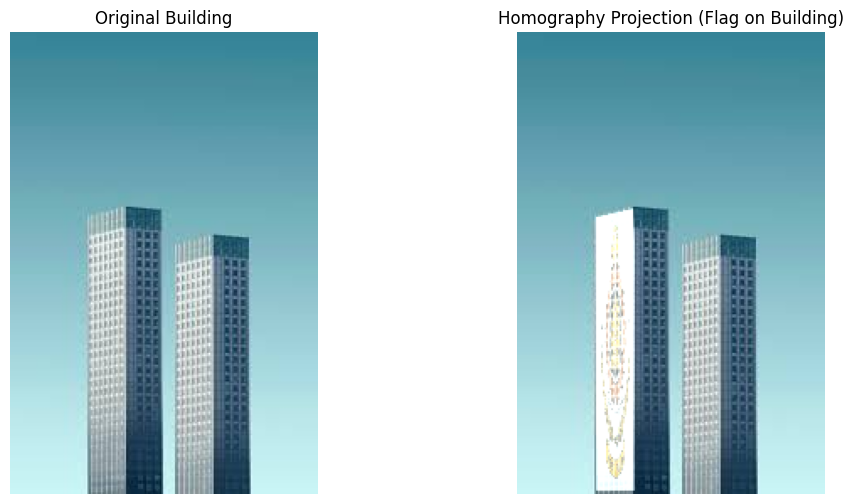

Homography Matrix:
 [[ 9.14973788e-02 -8.58294569e-03  4.70000000e+01]
 [-3.72706422e-02  6.55773574e-01  1.10000000e+02]
 [-1.36522499e-04 -1.82615866e-04  1.00000000e+00]]


In [ ]:
# --- Step 3: Compute homography matrix ---
H, _ = cv2.findHomography(pts_flag, points_building)

# --- Step 4: Warp flag image to match the building plane ---
warped_flag = cv2.warpPerspective(flag_img, H, (building_img.shape[1], building_img.shape[0]))

# --- Step 5: Create mask and blend images ---
mask = np.zeros_like(building_img, dtype=np.uint8)
cv2.fillConvexPoly(mask, points_building.astype(int), (255, 255, 255))

# Blend using weighted addition
blended = cv2.addWeighted(building_img, 1, warped_flag, 0.5, 0)

# --- Step 6: Visualization ---
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(building_img, cv2.COLOR_BGR2RGB))
plt.title("Original Building")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))
plt.title("Homography Projection (Flag on Building)")
plt.axis('off')
plt.show()

print("Homography Matrix:\n", H)


Detected keypoints: img1=2862, img5=3960
Filtered matches after Lowe's ratio test: 109


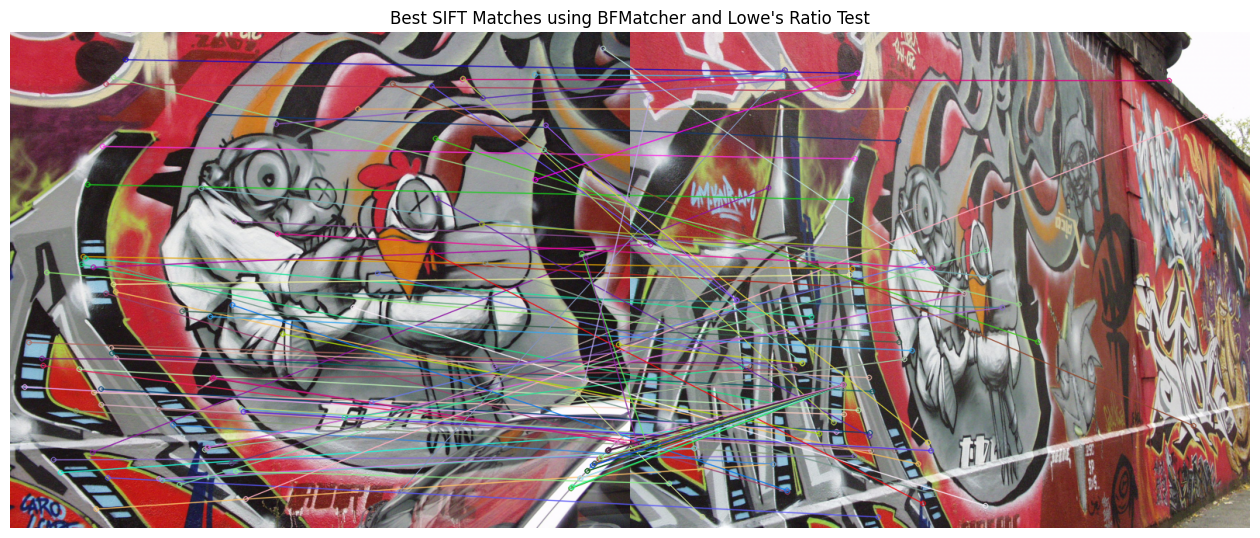

Saved result image as sift_matches.png


In [ ]:
# --- EN3160 Assignment 2 - Question 4 (Part a): SIFT Feature Matching ---
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Step 1: Load images ---
img1 = cv2.imread('/content/img1.ppm')
img5 = cv2.imread('/content/img5.ppm')

if img1 is None or img5 is None:
    raise FileNotFoundError("Please upload img1.ppm and img5.ppm to /content/")

# Convert to RGB for display
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img5_rgb = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)

# --- Step 2: Convert to grayscale for SIFT ---
img1_gray = cv2.cvtColor(img1_rgb, cv2.COLOR_RGB2GRAY)
img5_gray = cv2.cvtColor(img5_rgb, cv2.COLOR_RGB2GRAY)

# --- Step 3: Extract SIFT keypoints and descriptors ---
sift = cv2.SIFT_create(nOctaveLayers=3, contrastThreshold=0.09, edgeThreshold=25, sigma=1.0)
keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)
keypoints5, descriptors5 = sift.detectAndCompute(img5_gray, None)

print(f"Detected keypoints: img1={len(keypoints1)}, img5={len(keypoints5)}")

# --- Step 4: Brute Force Matching and Lowe's Ratio Test ---
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors5, k=2)

best_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        best_matches.append(m)

print(f"Filtered matches after Lowe's ratio test: {len(best_matches)}")

# --- Step 5: Draw the best matches ---
matched_img = cv2.drawMatches(
    img1_rgb, keypoints1,
    img5_rgb, keypoints5,
    best_matches, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(16, 8))
plt.imshow(matched_img)
plt.title("Best SIFT Matches using BFMatcher and Lowe's Ratio Test")
plt.axis('off')
plt.show()

# Optional: save output for report
cv2.imwrite('/content/sift_matches.png', cv2.cvtColor(matched_img, cv2.COLOR_RGB2BGR))
print("Saved result image as sift_matches.png")


Good matches after Lowe’s ratio test: 109
Best inlier count: 23 / 109


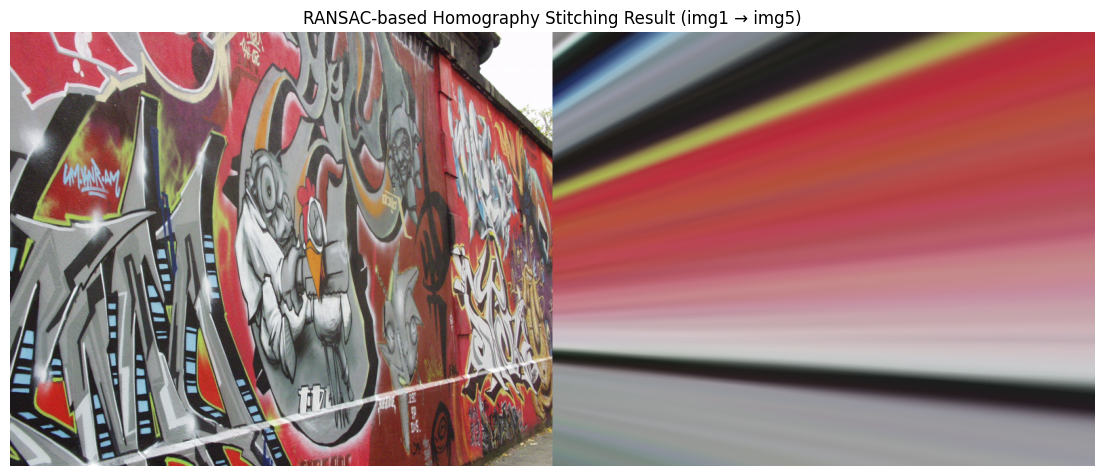

Saved warped image as homography_warp.png and final stitch as stitched_result.png


In [ ]:
# EN3160 - Assignment 2
# Task: SIFT feature matching + RANSAC-based homography + stitching

import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Load images ---
img1 = cv2.imread('/content/img1.ppm')
img5 = cv2.imread('/content/img5.ppm')

img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img5_gray = cv2.cvtColor(img5, cv2.COLOR_BGR2GRAY)

# --- Get SIFT descriptors ---
sift = cv2.SIFT_create(nOctaveLayers=3, contrastThreshold=0.09,
                       edgeThreshold=25, sigma=1)
keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)
keypoints5, descriptors5 = sift.detectAndCompute(img5_gray, None)

# --- Match using Brute Force Matcher ---
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors5, k=2)

# --- Lowe’s ratio test to filter best matches ---
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

print(f"Good matches after Lowe’s ratio test: {len(good_matches)}")

# --- Build correspondence points ---
src_full = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
dst_full = np.float32([keypoints5[m.trainIdx].pt for m in good_matches])

# --- Define helper: compute homography from 4 pairs ---
def compute_homography(src_points, dst_points):
    A = []
    for i in range(4):
        x, y = src_points[i][0], src_points[i][1]
        u, v = dst_points[i][0], dst_points[i][1]
        A.append([-x, -y, -1, 0, 0, 0, u * x, u * y, u])
        A.append([0, 0, 0, -x, -y, -1, v * x, v * y, v])
    A = np.asarray(A)
    _, _, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape(3, 3)
    return H / H[2, 2]

# --- Helper: count inliers given H ---
def get_inliers(src, dst, H, thres):
    src_h = np.hstack((src, np.ones((len(src), 1))))
    proj = (H @ src_h.T).T
    proj = proj[:, :2] / proj[:, [2]]
    error = np.linalg.norm(dst - proj, axis=1)
    inliers = np.where(error < thres)[0]
    return inliers

# --- RANSAC parameters ---
num_points = 4
thres = 4
iters = 200
best_homography = None
best_inlier_count = 0
best_inliers = None

# --- RANSAC loop ---
for i in range(iters):
    chosen_matches = np.random.choice(len(good_matches), num_points, replace=False)
    src_points = src_full[chosen_matches]
    dst_points = dst_full[chosen_matches]
    H = compute_homography(src_points, dst_points)

    inliers = get_inliers(src_full, dst_full, H, thres)
    if len(inliers) > best_inlier_count:
        best_inlier_count = len(inliers)
        best_homography = H
        best_inliers = inliers

print(f"Best inlier count: {best_inlier_count} / {len(good_matches)}")

# --- Warp and stitch images using best homography ---
h5, w5, _ = img5.shape
warped = cv2.warpPerspective(img1, best_homography, (w5 * 2, h5))
warped[0:h5, 0:w5] = img5

# --- Show results ---
plt.figure(figsize=(14,7))
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.title("RANSAC-based Homography Stitching Result (img1 → img5)")
plt.axis('off')
plt.show()

# --- Save outputs for report ---
cv2.imwrite('/content/homography_warp.png',
            cv2.warpPerspective(img1, best_homography, (w5, h5)))
cv2.imwrite('/content/stitched_result.png', warped)

print("Saved warped image as homography_warp.png and final stitch as stitched_result.png")
